In [50]:
from basebot import BaseBot
import yfinance as yf
from datetime import date
import pandas as pd
from sklearn.model_selection import train_test_split

In [51]:
bot = BaseBot("testbot")
data = bot.getData("AAPL", date(2015,1,1), date.today(), technical_indicators = ["all"])
data = bot.getTrend(data)
data = data.reset_index()

In [52]:
yfTick = yf.Ticker("AAPL")
earn = yfTick.earnings
earn

,Revenue,Earnings
Year,,
2019,260174000000,55256000000
2020,274515000000,57411000000
2021,365817000000,94680000000
2022,394328000000,99803000000


In [53]:
# stitch earnings column to the matching year
earningyears = list(earn.index)
for year in earningyears:
    mask = data['timestamp'].dt.year == year
    data.loc[mask, 'earnings'] = earn.loc[year, 'Earnings']
    data.loc[mask, 'revenue'] = earn.loc[year, 'Revenue']
data.tail()



,timestamp,ticker,open,high,low,close,volume,adj_close,volume_adi,volume_obv,...,others_dlr,others_cr,SMA_3,SMA_10,SMA_50,SMA_100,SMA_200,signal,earnings,revenue
1515,2022-11-03,AAPL,142.059998,142.800003,138.750000,138.880005,97918500,138.650009,1.070025e+09,-308094900.0,...,-4.333032,-13.080482,144.853333,148.685001,150.081199,0,155.91705,-1.0,9.980300e+10,3.943280e+11
1516,2022-11-04,AAPL,142.089996,142.669998,134.380005,138.380005,140716700,138.380005,1.065102e+09,-448811600.0,...,-0.360673,-13.393412,140.763336,147.796001,149.448199,0,155.91705,-1.0,9.980300e+10,3.943280e+11
1517,2022-11-07,AAPL,137.110001,139.149994,135.669998,138.919998,83374600,138.919998,1.137456e+09,-365437000.0,...,0.389466,-13.055452,138.726669,146.743001,148.954200,0,155.91705,-1.0,9.980300e+10,3.943280e+11
1518,2022-11-08,AAPL,140.410004,141.429993,137.490005,139.500000,89908500,139.500000,1.139282e+09,-275528500.0,...,0.416639,-12.692451,138.933334,145.459001,148.516599,0,155.91705,-1.0,9.980300e+10,3.943280e+11
1519,2022-11-09,AAPL,138.500000,138.539993,134.593307,134.869995,71760357,134.869995,1.077583e+09,-347288857.0,...,-3.375329,-15.590189,137.763331,144.011000,148.035799,0,155.79250,-1.0,9.980300e+10,3.943280e+11


In [54]:
## train test prep
data = data.set_index("timestamp")
X, Y = data.drop(["ticker", "signal"], axis=1), data["signal"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle = True)

In [55]:
# then min max scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
scaler = MinMaxScaler()
colnames = x_train.columns
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# convert back 2 pandas
x_train = pd.DataFrame(x_train, columns = colnames)
x_test = pd.DataFrame(x_test, columns = colnames)

In [56]:
# then lightgbm finally
from lightgbm import LGBMClassifier, plot_importance
model = LGBMClassifier()
model.fit(x_train, y_train)
scr_train = model.score(x_train, y_train)
print("train score: ", scr_train)
scr_test = model.score(x_test, y_test)
print("test score: ", scr_test)

train score:  1.0
test score:  0.9276315789473685


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

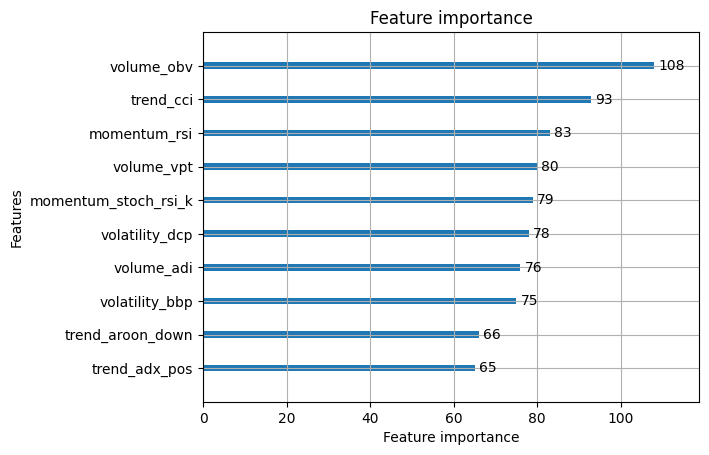

In [57]:
plot_importance(model, max_num_features=10)

## now confirm hypothesis with other stock

In [83]:
stock = "AAPL"
data = bot.getData(stock, date(2015,1,1), date.today(), technical_indicators = ["all"])
data = bot.getTrend(data)
data = data.reset_index()
yfTick = yf.Ticker(stock)
earn = yfTick.earnings
earningyears = list(earn.index)
for year in earningyears:
    mask = data['timestamp'].dt.year == year
    data.loc[mask, 'earnings'] = earn.loc[year, 'Earnings']
    data.loc[mask, 'revenue'] = earn.loc[year, 'Revenue']
data = data.set_index("timestamp")
data, Y = data.drop(["ticker", "signal"], axis=1), data["signal"]

In [84]:
## accuracy check
data_scaled = scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled, columns = colnames)
scr = model.score(data_scaled, Y)
print("msft model score: ", scr)

msft model score:  0.9855263157894737


In [85]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

startMoney = 10000
bestWin = -9999999
bestSettings = dict()

for lookback in tqdm([1,5,7,10,13,15,20]):
    money = startMoney
    stocks = 0
    portfolio = []
    baseline = []
    baselineHowmany = money / data.iloc[0]["adj_close"]
    for i in range(lookback, len(data)):
        crntPrice = data.iloc[i]["adj_close"]
        preds = model.predict(data_scaled.iloc[i-lookback:i])
        # print("preds: ", preds)
        pred = np.median(preds)
        if pred == 1 and money > 10 and stocks == 0:
            # buy
            howMany = money / crntPrice * 0.98
            cost = howMany * crntPrice
            money -= cost
            stocks = howMany
        elif pred == -1 and stocks > 0:
            # sell
            money += stocks * crntPrice
            stocks = 0
        portfolio.append(money + stocks * crntPrice)
        baseline.append(baselineHowmany * crntPrice)
    if portfolio[-1] > bestWin:
        bestWin = portfolio[-1]
        bestSettings = dict(lookback = lookback, win=portfolio[-1], baselineWin = baselineHowmany, portfolio = portfolio, baseline = baseline)
print("best win: ", bestWin, lookback)

100%|██████████| 7/7 [00:11<00:00,  1.70s/it]

best win:  41481.72706863098 20


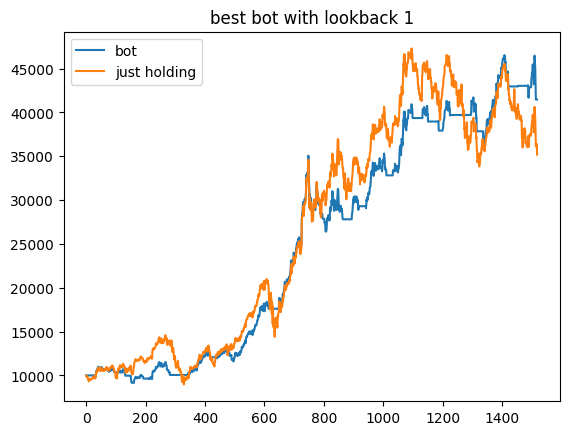

In [86]:
# just holding vs portfolio:
plt.plot(bestSettings["portfolio"], label = "bot")
plt.plot(bestSettings["baseline"], label = "just holding")
plt.title(f"best LightGBM with lookback {bestSettings['lookback']}")
plt.legend()


## next test XGBoost

In [87]:
import gc
gc.collect()

2203

In [95]:
tock = "AAPL"
data = bot.getData(stock, date(2015,1,1), date.today(), technical_indicators = ["all"])
data = bot.getTrend(data)
data = data.reset_index()
yfTick = yf.Ticker(stock)
earn = yfTick.earnings
earningyears = list(earn.index)
for year in earningyears:
    mask = data['timestamp'].dt.year == year
    data.loc[mask, 'earnings'] = earn.loc[year, 'Earnings']
    data.loc[mask, 'revenue'] = earn.loc[year, 'Revenue']
data = data.set_index("timestamp")
data, Y = data.drop(["ticker", "signal"], axis=1), data["signal"]

# xgb needs 0 and 1
Y = Y.replace(-1, 0)
## train test and stuff
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle = True)
scaler = MinMaxScaler()
colnames = x_train.columns
x_train = scaler.fit_transform(x_train)
data_scaled = scaler.transform(data)
x_test = scaler.transform(x_test)
# convert back 2 pandas
x_train = pd.DataFrame(x_train, columns = colnames)
x_test = pd.DataFrame(x_test, columns = colnames)
data_scaled = pd.DataFrame(data_scaled, columns = colnames)

In [96]:
from xgboost import XGBClassifier

model = XGBClassifier(n_jobs = -1)
model.fit(x_train, y_train)
scr_train = model.score(x_train, y_train)
print("train scr: ", scr_train)
scr_test = model.score(x_test, y_test)
print("test scr: ", scr_test)

train scr:  1.0
test scr:  0.9078947368421053


XGB managed test scr:  0.93 compared to 0.85 of lightgbm

In [97]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

startMoney = 10000
bestWin = -9999999
bestSettings = dict()

for lookback in tqdm([1,5,7,10,13,15,20]):
    money = startMoney
    stocks = 0
    portfolio = []
    baseline = []
    baselineHowmany = money / data.iloc[0]["adj_close"]
    for i in range(lookback, len(data)):
        crntPrice = data.iloc[i]["adj_close"]
        preds = model.predict(data_scaled.iloc[i-lookback:i])
        # print("preds: ", preds)
        pred = np.median(preds)
        ## for xgb we need to convert 0 to -1
        if pred == 0:
            pred = -1
        if pred == 1 and money > 10 and stocks == 0:
            # buy
            howMany = money / crntPrice * 0.98
            cost = howMany * crntPrice
            money -= cost
            stocks = howMany
        elif pred == -1 and stocks > 0:
            # sell
            money += stocks * crntPrice
            stocks = 0
        portfolio.append(money + stocks * crntPrice)
        baseline.append(baselineHowmany * crntPrice)
    if portfolio[-1] > bestWin:
        bestWin = portfolio[-1]
        bestSettings = dict(lookback = lookback, win=portfolio[-1], baselineWin = baselineHowmany, portfolio = portfolio, baseline = baseline)
print("best win: ", bestWin, lookback)

100%|██████████| 7/7 [00:29<00:00,  4.26s/it]

best win:  38780.7333264305 20


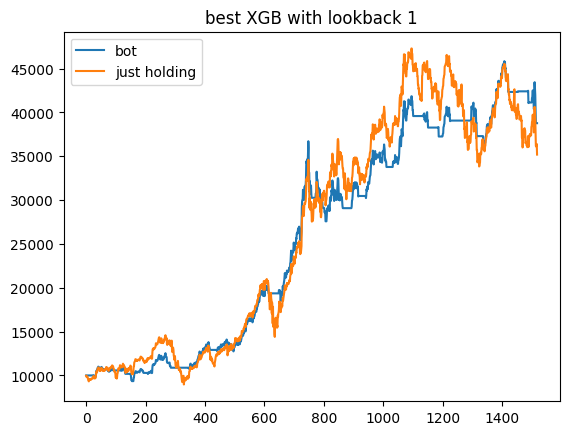

In [98]:
# just holding vs portfolio:
plt.plot(bestSettings["portfolio"], label = "bot")
plt.plot(bestSettings["baseline"], label = "just holding")
plt.title(f"best XGB with lookback {bestSettings['lookback']}")
plt.legend()
